In [3]:
import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

# Read the GeoPackage file
City_MIcat = gpd.read_file('Nairobi_Reference_MIcat.gpkg')

# Convert from Mollweide (ESRI:54009) to WGS84 (EPSG:4326)
City_MIcat = City_MIcat.to_crs(epsg=4326)

# Convert to a pandas DataFrame without the geometry column
City_MIcat_df = pd.DataFrame(City_MIcat.drop(columns='geometry'))

# Replace NaN with 0 in population columns
City_MIcat_df['Pop_stddev'].fillna(0, inplace=True)
City_MIcat_df['Pop_mean'].fillna(0, inplace=True)

# Map categorical values to integers
label_map = {'Low': 0, 'Med': 1, 'High': 2}
City_MIcat_df['MI_cat'] = City_MIcat_df['MI_cat'].map(label_map)

# Separate the data into training and prediction sets
train_df = City_MIcat_df[City_MIcat_df['MI_cat'].notna()]  # Data with MI_cat values (0, 1, 2)
predict_df = City_MIcat_df[City_MIcat_df['MI_cat'].isna()]  # Data with MI_cat as NaN

# Define feature columns
feature_columns = ['SDS_bin', 'roadlength', 'Pop_mean', 'Pop_stddev', 'ISL_bin', 'Intersections', 'Distance_mean']

# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(train_df[feature_columns], train_df['MI_cat'].astype(int), test_size=0.2, random_state=42)

# Fit the Random Forest model
rf = RandomForestClassifier(n_estimators=1000, max_features='sqrt', oob_score=True, n_jobs=-1)
rf.fit(x_train, y_train)

# Perform 10-Fold Cross validation
cv_scores_rf = cross_val_score(rf, x_train, y_train, cv=10, n_jobs=-1)
print("10-Fold Cross-Validation Scores for RF: ", cv_scores_rf)
print("Mean CV Score: ", np.mean(cv_scores_rf))

# Evaluate on the test set
test_accuracy = accuracy_score(y_test, rf.predict(x_test))
print("Accuracy on the Test Set: ", test_accuracy)

# Check if there are any missing values in 'MI_cat'
missing_count = City_MIcat_df['MI_cat'].isna().sum()
print(f"Missing values in 'MI_cat': {missing_count}")

if missing_count > 0:
    # Prepare x_predict using the same features as x_train
    x_predict = City_MIcat_df.loc[City_MIcat_df['MI_cat'].isna(), feature_columns]

    # Ensure x_predict is not empty
    if not x_predict.empty:
        # Predict the missing values
        predicted_values = rf.predict(x_predict)

        # Check the lengths to ensure they match
        predicted_count = len(predicted_values)
        print(f"Missing Count: {missing_count}, Predicted Count: {predicted_count}")

        # Assign the predicted values back to the original DataFrame
        City_MIcat_df.loc[City_MIcat_df['MI_cat'].isna(), 'MI_cat'] = predicted_values

        # Save the updated DataFrame with predictions
        output_file_predictions = 'Nairobi_MIcat_with_predictions.csv'
        City_MIcat_df.to_csv(output_file_predictions, index=False)
        print(f"Predictions saved to {output_file_predictions}")

        # Prepare the ingestion CSV with the required columns
        ingestion_df = City_MIcat_df.copy()
        ingestion_df['latitude'] = City_MIcat.geometry.centroid.y
        ingestion_df['longitude'] = City_MIcat.geometry.centroid.x
        ingestion_df['lat_min'] = City_MIcat.geometry.bounds['miny']
        ingestion_df['lat_max'] = City_MIcat.geometry.bounds['maxy']
        ingestion_df['lon_min'] = City_MIcat.geometry.bounds['minx']
        ingestion_df['lon_max'] = City_MIcat.geometry.bounds['maxx']
        ingestion_df['result'] = ingestion_df['MI_cat']  # Ensure this column is either 0, 1, or 2

        # Select only the required columns
        ingestion_df = ingestion_df[['latitude', 'longitude', 'lat_min', 'lat_max', 'lon_min', 'lon_max', 'result']]

        # Save the ingestion CSV
        output_file_ingestion = 'Nairobi_MIcat_ingestion_.csv'
        ingestion_df.to_csv(output_file_ingestion, index=False)
        print(f"Ingestion data saved to {output_file_ingestion}")


10-Fold Cross-Validation Scores for RF:  [0.86538462 0.71153846 0.76923077 0.71153846 0.75       0.75
 0.76470588 0.58823529 0.7254902  0.66666667]
Mean CV Score:  0.7302790346907995
Accuracy on the Test Set:  0.7131782945736435
Missing values in 'MI_cat': 109818
Missing Count: 109818, Predicted Count: 109818
Predictions saved to Nairobi_MIcat_with_predictions.csv


/tmp/ipykernel_3112/2033268980.py:75: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ingestion_df['latitude'] = City_MIcat.geometry.centroid.y
/tmp/ipykernel_3112/2033268980.py:76: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ingestion_df['longitude'] = City_MIcat.geometry.centroid.x


Ingestion data saved to Nairobi_MIcat_ingestion_.csv


In [ ]:
### Recalc with confusion matrix (if needed)

10-Fold Cross-Validation Scores for RF:  [0.86538462 0.73076923 0.76923077 0.67307692 0.76923077 0.73076923
 0.76470588 0.58823529 0.70588235 0.66666667]
Mean CV Score:  0.7263951734539971
Accuracy on the Test Set:  0.7131782945736435
Confusion Matrix:
[[45  1 11]
 [ 3  0  8]
 [12  2 47]]


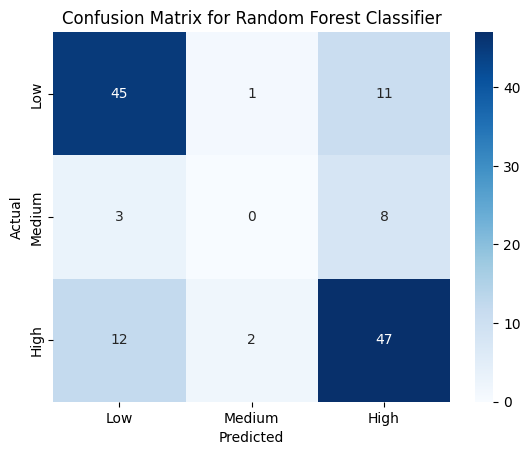

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Read the GeoPackage file
City_MIcat = gpd.read_file('Nairobi_Reference_MIcat.gpkg')

# Convert from Mollweide (ESRI:54009) to WGS84 (EPSG:4326)
City_MIcat = City_MIcat.to_crs(epsg=4326)

# Convert to a pandas DataFrame without the geometry column
City_MIcat_df = pd.DataFrame(City_MIcat.drop(columns='geometry'))

# Replace NaN with 0 in population columns
City_MIcat_df['Pop_stddev'].fillna(0, inplace=True)
City_MIcat_df['Pop_mean'].fillna(0, inplace=True)

# Map categorical values to integers
label_map = {'Low': 0, 'Med': 1, 'High': 2}
City_MIcat_df['MI_cat'] = City_MIcat_df['MI_cat'].map(label_map)

# Separate the data into training and prediction sets
train_df = City_MIcat_df[City_MIcat_df['MI_cat'].notna()]  # Data with MI_cat values (0, 1, 2)
predict_df = City_MIcat_df[City_MIcat_df['MI_cat'].isna()]  # Data with MI_cat as NaN

# Define feature columns
feature_columns = ['SDS_bin', 'roadlength', 'Pop_mean', 'Pop_stddev', 'ISL_bin', 'Intersections', 'Distance_mean']

# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(train_df[feature_columns], train_df['MI_cat'].astype(int), test_size=0.2, random_state=42)

# Fit the Random Forest model
rf = RandomForestClassifier(n_estimators=1000, max_features='sqrt', oob_score=True, n_jobs=-1)
rf.fit(x_train, y_train)

# Perform 10-Fold Cross validation
cv_scores_rf = cross_val_score(rf, x_train, y_train, cv=10, n_jobs=-1)
print("10-Fold Cross-Validation Scores for RF: ", cv_scores_rf)
print("Mean CV Score: ", np.mean(cv_scores_rf))

# Evaluate on the test set
y_pred = rf.predict(x_test)
test_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on the Test Set: ", test_accuracy)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'Medium', 'High'], yticklabels=['Low', 'Medium', 'High'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Random Forest Classifier')
plt.show()


Feature Importances:
         Feature  Importance
2       Pop_mean    0.388029
6  Distance_mean    0.313704
0        SDS_bin    0.113547
3     Pop_stddev    0.071775
4        ISL_bin    0.053077
1     roadlength    0.053054
5  Intersections    0.006813


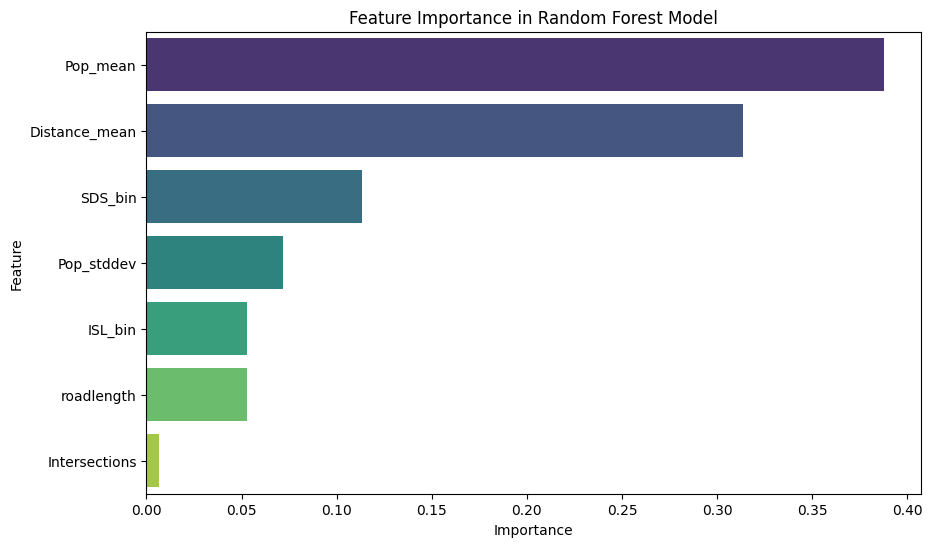

In [4]:
# Feature importance
feature_importances = rf.feature_importances_
features = pd.DataFrame({'Feature': feature_columns, 'Importance': feature_importances})

# Sort features by importance
features = features.sort_values(by='Importance', ascending=False)

# Display feature importance
print("Feature Importances:")
print(features)

# Plotting the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=features, palette='viridis')
plt.title('Feature Importance in Random Forest Model')
plt.show()